In [29]:
import numpy as np
import matplotlib.pyplot as plt
import os

from joblib import Parallel, delayed, parallel_backend
# from psiam_tied_dv_map_utils_for_noise import psiam_tied_data_gen_wrapper_noise_change_no_L_T0_change
from psiam_tied_dv_map_utils_with_PDFs import all_RTs_fit_OPTIM_V_A_change_added_noise_fn, up_RTs_fit_OPTIM_V_A_change_added_noise_fn, down_RTs_fit_OPTIM_V_A_change_added_noise_fn, PA_with_LEDON_2
from psiam_tied_dv_map_utils_with_PDFs import up_RTs_fit_OPTIM_V_A_change_gamma_omega_fn, down_RTs_fit_OPTIM_V_A_change_gamma_omega_fn
import pandas as pd
import random
from tqdm.notebook import tqdm
from joblib import Parallel, delayed
from scipy.integrate import trapezoid as trapz
from pyvbmc import VBMC
import corner
from diagnostics_class import Diagnostics
from psiam_tied_dv_map_utils_with_PDFs import all_RTs_fit_OPTIM_fn, CDF_RT_fn

# data

In [2]:
# repeat_trial, T16, S7
og_df = pd.read_csv('../out_LED.csv')
df = og_df[ og_df['repeat_trial'].isin([0,2]) | og_df['repeat_trial'].isna() ]
session_type = 7    
df = df[ df['session_type'].isin([session_type]) ]
training_level = 16
df = df[ df['training_level'].isin([training_level]) ]


# t_stim, t_LED, ABL, ILD
t_stim_and_led_tuple = [(row['intended_fix'], row['intended_fix'] - row['LED_onset_time']) for _, row in df.iterrows()]
ABL_arr = df['ABL'].unique(); ABL_arr.sort()
ILD_arr = df['ILD'].unique(); ILD_arr.sort()


# 1 is right , -1 is left
df['choice'] = df['response_poke'].apply(lambda x: 1 if x == 3 else (-1 if x == 2 else random.choice([1, -1])))
# 1 or 0 if the choice was correct or not
df['correct'] = (df['ILD'] * df['choice']).apply(lambda x: 1 if x > 0 else 0)


# VBMC

## data

In [3]:
# LED OFF
df_led_off = df[df['LED_trial'] == 0]
print(f'len of LED off: {len(df_led_off)}')

# remove ILD 16
df_led_off = df_led_off[ ~df_led_off['ILD'].isin([16, -16]) ]
# TEMP: remove ILD 8 also
df_led_off = df_led_off[ ~df_led_off['ILD'].isin([8, -8]) ]
print(f'len of ILD 16, 8 removed: {len(df_led_off)}')

# valid trials
df_led_off_valid_trials = df_led_off[df_led_off['success'].isin([1,-1])]
print(f'len of led off valid trials = {len(df_led_off_valid_trials)}')

# remove trials with RT > 1s
df_led_off_valid_trials = df_led_off_valid_trials[df_led_off_valid_trials['timed_fix'] - df_led_off_valid_trials['intended_fix'] < 1]
print(f'len of valid trials < 1s : {len(df_led_off_valid_trials)}')

len of LED off: 66226
len of ILD 16, 8 removed: 39722
len of led off valid trials = 31945
len of valid trials < 1s : 31308


# take only one condition

In [4]:
df_led_off_valid_trials['ABL'].unique(), df_led_off_valid_trials['ILD'].unique()

(array([40, 60, 20]), array([ 1., -2.,  2., -1.,  4., -4.]))

In [5]:
conditions = {'ABL': [40], 'ILD': [2]}

# Applying the filter
df_led_off_valid_trials_cond_filtered = df_led_off_valid_trials[
    (df_led_off_valid_trials['ABL'].isin(conditions['ABL'])) & 
    (df_led_off_valid_trials['ILD'].isin(conditions['ILD']))
]

In [6]:
print(f'lenm of conditioned trials = {len(df_led_off_valid_trials_cond_filtered)}')
ABLs_cond = df_led_off_valid_trials_cond_filtered['ABL'].unique()
ILDs_cond = df_led_off_valid_trials_cond_filtered['ILD'].unique()
print(ABLs_cond)
print(ILDs_cond)

lenm of conditioned trials = 1716
[40]
[2.]


## params

In [7]:
# Proactive params
V_A = 1.6
theta_A = 2.53
V_A_post_LED = V_A # LED OFF

# delays
t_A_aff = -0.187
# t_E_aff = 0.075 TO BE FITTED
del_go = 0.13 # TO BE FITTED

Z_E = 0
K_max = 10

# LED off - no noise
# rate_lambda = 0.12 # TO BE FITTED
noise = 0

## loglike fn

In [8]:
weight_of_tacho_like = 1

In [9]:
def compute_loglike_trial(row, gamma, omega, t_E_aff):
    # data
    rt = row['timed_fix']
    t_stim = row['intended_fix']
    t_LED = row['intended_fix'] - row['LED_onset_time']

    response_poke = row['response_poke']
    

    t_pts = np.arange(t_stim, t_stim + 1, 0.001)
    P_A_LED_change = np.array([PA_with_LEDON_2(i, V_A, V_A_post_LED, theta_A, 0, t_LED, t_A_aff) for i in t_pts])
    area_btn_stim_and_1s = trapz(P_A_LED_change, t_pts)
    trunc_factor_p_joint = area_btn_stim_and_1s
        
    if response_poke == 3:
        # up
        P_joint_rt_choice = up_RTs_fit_OPTIM_V_A_change_gamma_omega_fn(rt, t_LED, V_A, V_A_post_LED, theta_A,\
                                                                    gamma, omega, t_stim, t_A_aff, t_E_aff, del_go, K_max)
    elif response_poke == 2:
        # down
        P_joint_rt_choice = down_RTs_fit_OPTIM_V_A_change_gamma_omega_fn(rt, t_LED, V_A, V_A_post_LED, theta_A,\
                                                                    gamma, omega, t_stim, t_A_aff, t_E_aff, del_go, K_max)
    

    # P_rt =  all_RTs_fit_OPTIM_fn(rt, V_A, theta_A, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, t_stim, t_A_aff, t_E_aff, 0, K_max)
    # cdf_t_stim_plus_1 = CDF_RT_fn(t_stim + 1, V_A, theta_A, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, t_stim, t_A_aff, t_E_aff, 0, K_max)
    # cdf_t_stim =   CDF_RT_fn(t_stim, V_A, theta_A, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, t_stim, t_A_aff, t_E_aff, 0, K_max)  
    # trunc_factor_p_rt = cdf_t_stim_plus_1 - cdf_t_stim

    P_joint_rt_choice_trunc = max(P_joint_rt_choice / (trunc_factor_p_joint + 1e-10), 1e-10)
    # P_rt_trunc = max(P_rt / (trunc_factor_p_rt + 1e-10), 1e-10)


    # wt_log_like = (1 - weight_of_tacho_like)*np.log(P_rt_trunc) + weight_of_tacho_like*np.log(P_joint_rt_choice_trunc)
    wt_log_like = weight_of_tacho_like*np.log(P_joint_rt_choice_trunc)


    return wt_log_like


def vbmc_loglike_fn(params):
    gamma, omega, t_E_aff = params

    all_loglike = Parallel(n_jobs=30)(delayed(compute_loglike_trial)(row, gamma, omega, t_E_aff) \
                                     for _, row in df_led_off_valid_trials_cond_filtered.iterrows())
    
    return np.sum(all_loglike)

## bounds

In [10]:
# rate_lambda_bounds = [0.01, 0.2]
# rate_lambda_plausible_bounds = [0.02, 0.15]

# theta_E_bounds = [20, 80]
# theta_E_plausible_bounds = [40, 50]

# T_0_bounds = [0.1 * (1e-3), 5 * (1e-3)]
# T_0_plausible_bounds = [0.6 * (1e-3), 1.5 * (1e-3)]

# del_go_bounds = [0, 0.2]
# del_go_plausible_bounds = [0.01, 0.15]

t_E_aff_bounds = [0, 1]
t_E_aff_plausible_bounds = [0.01, 0.2]

gamma_bounds = [0.02, 2]
gamma_plausible_bounds = [0.09, 0.9]

omega_bounds = [0.05, 50]
omega_plausible_bounds = [0.5, 10]

In [11]:
(2 * (10**(2 * 0.15)) ) / (0.6 * 1e-3 * (40**2))

4.1567964895184994

## prior

In [12]:
def trapezoidal_logpdf(x, a, b, c, d):
    if x < a or x > d:
        return -np.inf  # Logarithm of zero
    area = ((b - a) + (d - c)) / 2 + (c - b)
    h_max = 1.0 / area  # Height of the trapezoid to normalize the area to 1
    
    if a <= x <= b:
        pdf_value = ((x - a) / (b - a)) * h_max
    elif b < x < c:
        pdf_value = h_max
    elif c <= x <= d:
        pdf_value = ((d - x) / (d - c)) * h_max
    else:
        pdf_value = 0.0  # This case is redundant due to the initial check

    if pdf_value <= 0.0:
        return -np.inf
    else:
        return np.log(pdf_value)
    

def vbmc_prior_fn(params):
    gamma, omega, t_E_aff = params
    gamma_logpdf = trapezoidal_logpdf(gamma, gamma_bounds[0], gamma_plausible_bounds[0], gamma_plausible_bounds[1], gamma_bounds[1])
    omega_logpdf = trapezoidal_logpdf(omega, omega_bounds[0], omega_plausible_bounds[0], omega_plausible_bounds[1], omega_bounds[1])
    t_E_aff_logpdf = trapezoidal_logpdf(t_E_aff, t_E_aff_bounds[0], t_E_aff_plausible_bounds[0], t_E_aff_plausible_bounds[1], t_E_aff_bounds[1])
    return gamma_logpdf + omega_logpdf + t_E_aff_logpdf

## prior + loglike

In [13]:
def vbmc_joint_fn(params):
    priors = vbmc_prior_fn(params)
    loglike = vbmc_loglike_fn(params)

    return priors + loglike

## vbmc

In [14]:
# lb = np.array([rate_lambda_bounds[0], T_0_bounds[0], theta_E_bounds[0], t_E_aff_bounds[0]])
# ub = np.array([rate_lambda_bounds[1], T_0_bounds[1], theta_E_bounds[1], t_E_aff_bounds[1] ])

# plb = np.array([rate_lambda_plausible_bounds[0], T_0_plausible_bounds[0], theta_E_plausible_bounds[0], t_E_aff_plausible_bounds[0]])
# pub = np.array([rate_lambda_plausible_bounds[1], T_0_plausible_bounds[1], theta_E_plausible_bounds[1], t_E_aff_plausible_bounds[1]])

# np.random.seed(42)
# rate_lambda_0 = np.random.uniform(rate_lambda_plausible_bounds[0], rate_lambda_plausible_bounds[1])
# T_0_0 = np.random.uniform(T_0_plausible_bounds[0], T_0_plausible_bounds[1])
# theta_E_0 = np.random.uniform(theta_E_plausible_bounds[0], theta_E_plausible_bounds[1])
# t_E_aff_0 = np.random.uniform(t_E_aff_plausible_bounds[0], t_E_aff_plausible_bounds[1])

# x_0 = np.array([rate_lambda_0, T_0_0, theta_E_0, t_E_aff_0])

# vbmc = VBMC(vbmc_joint_fn, x_0, lb, ub, plb, pub, options={'display': 'on'})
# vp, results = vbmc.optimize()

# Define bounds
lb = np.array([gamma_bounds[0], omega_bounds[0], t_E_aff_bounds[0]])
ub = np.array([gamma_bounds[1], omega_bounds[1], t_E_aff_bounds[1]])

plb = np.array([gamma_plausible_bounds[0], omega_plausible_bounds[0], t_E_aff_plausible_bounds[0]])
pub = np.array([gamma_plausible_bounds[1], omega_plausible_bounds[1], t_E_aff_plausible_bounds[1]])

# Initialize with random values within plausible bounds
np.random.seed(42)
gamma_0 = np.random.uniform(gamma_plausible_bounds[0], gamma_plausible_bounds[1])
omega_0 = np.random.uniform(omega_plausible_bounds[0], omega_plausible_bounds[1])
t_E_aff_0 = np.random.uniform(t_E_aff_plausible_bounds[0], t_E_aff_plausible_bounds[1])

x_0 = np.array([gamma_0, omega_0, t_E_aff_0])

# Run VBMC
vbmc = VBMC(vbmc_joint_fn, x_0, lb, ub, plb, pub, options={'display': 'on'})
vp, results = vbmc.optimize()


Reshaping x0 to row vector.
Reshaping lower bounds to (1, 3).
Reshaping upper bounds to (1, 3).
Reshaping plausible lower bounds to (1, 3).
Reshaping plausible upper bounds to (1, 3).
Casting upper bounds to floating point.
Beginning variational optimization assuming EXACT observations of the log-joint.
 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action
     0         10         994.84       124.79          inf        2        inf     start warm-up
     1         15        1010.44        93.19       264.91        2        inf     
     2         20         986.73        20.18       220.80        2    4.4e+03     
     3         25        1064.90        15.16       138.24        2   2.97e+03     
     4         30        1173.85         8.75       307.19        2    6.3e+03     
     5         35        1172.70         3.84        96.20        2   1.87e+03     
     6         40        1212.98         4.22        62.23        2   1.35e+03     
    

# Diagnostics

## corner

In [15]:
# sample from vp
vp_samples = vp.sample(int(1e5))[0]

# rate_lambda_samples = vp_samples[:, 0]
# T0_samples = vp_samples[:, 1]
# theta_E_samples = vp_samples[:, 2]
# t_E_aff_samples = vp_samples[:, 3]
gamma_samples = vp_samples[:, 0]
omega_samples = vp_samples[:, 1]
t_E_aff_samples = vp_samples[:, 2]

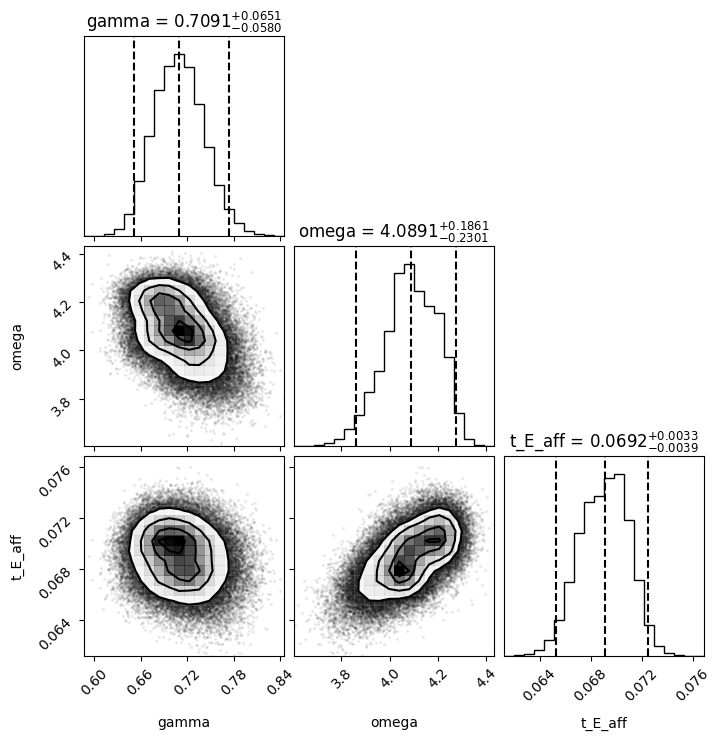

In [16]:
# plot the corner plot
corner_samples = np.vstack([gamma_samples, omega_samples, t_E_aff_samples]).T
percentiles = np.percentile(corner_samples, [0, 100], axis=0)
_ranges = [(percentiles[0, i], percentiles[1, i]) for i in np.arange(corner_samples.shape[1])]
param_labels = [ 'gamma', 'omega', 't_E_aff']

corner.corner(
    corner_samples,
    labels=param_labels,
    show_titles=True,
    quantiles=[0.025, 0.5, 0.975],
    range=_ranges,
    title_fmt=".4f"
);


In [17]:
vbmc.save('per_cond_vbmc_A40_I2.pkl', overwrite=True)

# Diagnostics

## exp data

In [55]:
# LED off
df_led_off = df[df['LED_trial'] == 0]

# < 1s RTs
df_led_off = df_led_off[df_led_off['timed_fix'] - df_led_off['intended_fix'] < 1]
# remove truncated aborts
data_df_led_off_with_aborts = df_led_off[ ~( (df_led_off['abort_event'] == 3) & (df_led_off['timed_fix'] < 0.3) ) ]
# renaming
data_df_led_off_with_aborts = data_df_led_off_with_aborts.rename(
    columns={'timed_fix': 'rt', 'intended_fix': 't_stim'}
)

# with aborts only relevant stim
data_df_led_off_with_aborts_cond_filtered = data_df_led_off_with_aborts[
    (data_df_led_off_with_aborts['ABL'].isin(conditions['ABL'])) & 
    (data_df_led_off_with_aborts['ILD'].isin(conditions['ILD']))
]

# take only valid trials
data_df_led_off_valid = data_df_led_off_with_aborts[ data_df_led_off_with_aborts['success'].isin([1,-1]) ]

# cond filtered
df_led_off_valid_trials_cond_filtered = data_df_led_off_valid[
    (data_df_led_off_valid['ABL'].isin(conditions['ABL'])) & 
    (data_df_led_off_valid['ILD'].isin(conditions['ILD']))
]

df_led_off_valid_trials_cond_filtered['ABL'].unique(), df_led_off_valid_trials_cond_filtered['ILD'].unique()

(array([40]), array([2.]))

In [56]:
### 1. RTs up and down
bins = np.arange(0,1,0.01)
bin_centers = (bins[:-1] + bins[1:]) / 2
## data
data_up = df_led_off_valid_trials_cond_filtered[df_led_off_valid_trials_cond_filtered['choice'] == 1]
data_down = df_led_off_valid_trials_cond_filtered[df_led_off_valid_trials_cond_filtered['choice'] == -1]

data_up_rt = data_up['rt'] - data_up['t_stim']
data_up_rt_hist, _ = np.histogram(data_up_rt, bins=bins, density=True)

data_down_rt = data_down['rt'] - data_down['t_stim']
data_down_rt_hist, _ = np.histogram(data_down_rt, bins=bins, density=True)

frac_up_data = len(data_up) / len(data_df_led_off_with_aborts_cond_filtered)
frac_down_data = len(data_down) / len(data_df_led_off_with_aborts_cond_filtered)

In [53]:
# up theory
N_theory = int(1e3)
rand_indices = np.random.randint(0, len(t_stim_and_led_tuple), size=N_theory)
t_pts = np.arange(0, 1, 0.02)

# Compute mean values for gamma, omega, and t_E_aff
gamma = gamma_samples.mean()
omega = omega_samples.mean()
t_E_aff = t_E_aff_samples.mean()

print(f'gamma = {gamma}, omega = {omega}, t_E_Afff = { t_E_aff}')

up_rt_theory_samples = np.zeros((N_theory, len(t_pts)))

# Function to compute one sample
def compute_up_rt_theory_sample(idx):
   
    t_stim, t_LED = t_stim_and_led_tuple[rand_indices[idx]]

    # Compute truncation factor
    # t_pts_trunc = np.arange(t_stim, t_stim + 1, 0.001)
    # P_A_LED_change = np.array([PA_with_LEDON_2(i, V_A, V_A_post_LED, theta_A, 0, t_LED, t_A_aff) for i in t_pts_trunc])
    # area_btn_stim_and_1s = trapz(P_A_LED_change, t_pts_trunc)
    trunc_factor_p_joint = 1

    # Compute and return the truncated values
    return np.array([
        max(
            up_RTs_fit_OPTIM_V_A_change_gamma_omega_fn(rt + t_stim, t_LED, V_A, V_A_post_LED, theta_A,
                                                        gamma, omega, t_stim, t_A_aff, t_E_aff, del_go, K_max) 
            / (trunc_factor_p_joint + 1e-50), 1e-50
        ) for rt in t_pts
    ])

# Parallel computation
results = Parallel(n_jobs=15)(delayed(compute_up_rt_theory_sample)(idx) for idx in tqdm(range(N_theory)))

# Convert results to numpy array
up_rt_theory_samples = np.array(results)


gamma = 0.7098007519751065, omega = 4.087984770751034, t_E_Afff = 0.06905887832745537


  0%|          | 0/1000 [00:00<?, ?it/s]

In [60]:
# up theory

down_rt_theory_samples = np.zeros((N_theory, len(t_pts)))

# Function to compute one sample
def compute_down_rt_theory_sample(idx):
   
    t_stim, t_LED = t_stim_and_led_tuple[rand_indices[idx]]

    # Compute truncation factor
    # t_pts_trunc = np.arange(t_stim, t_stim + 1, 0.001)
    # P_A_LED_change = np.array([PA_with_LEDON_2(i, V_A, V_A_post_LED, theta_A, 0, t_LED, t_A_aff) for i in t_pts_trunc])
    # area_btn_stim_and_1s = trapz(P_A_LED_change, t_pts_trunc)
    trunc_factor_p_joint = 1

    # Compute and return the truncated values
    return np.array([
        max(
            down_RTs_fit_OPTIM_V_A_change_gamma_omega_fn(rt + t_stim, t_LED, V_A, V_A_post_LED, theta_A,
                                                        gamma, omega, t_stim, t_A_aff, t_E_aff, del_go, K_max) 
            / (trunc_factor_p_joint + 1e-50), 1e-50
        ) for rt in t_pts
    ])

# Parallel computation
results = Parallel(n_jobs=15)(delayed(compute_down_rt_theory_sample)(idx) for idx in tqdm(range(N_theory)))

# Convert results to numpy array
down_rt_theory_samples = np.array(results)


  0%|          | 0/1000 [00:00<?, ?it/s]

Up areas: data = 0.673, theory = 0.668
Down areas: data = 0.184, theory  = 0.188


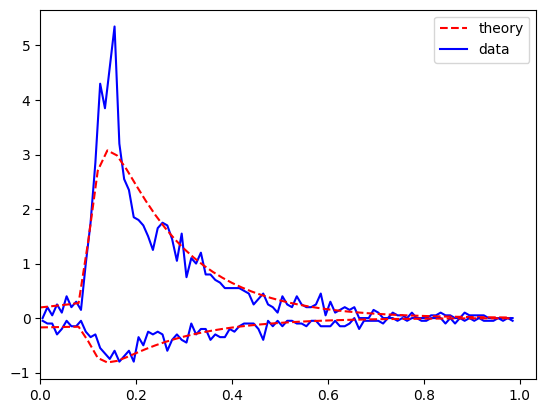

In [65]:
plt.plot(bin_centers, data_up_rt_hist * frac_up_data, color='b')
up_theory_mean = np.mean(up_rt_theory_samples, axis=0)
plt.plot(t_pts, up_theory_mean, label='theory', color='r', ls='--')

plt.plot(bin_centers, -data_down_rt_hist * frac_down_data, color='b', label='data')
down_theory_mean = np.mean(down_rt_theory_samples, axis=0)
plt.plot(t_pts, -down_theory_mean, color='r', ls='--')
plt.xlim(left = 0)
plt.legend()

# trapz(up_theory_mean, t_pts), frac_up_data
print(f'Up areas: data = {frac_up_data :.3f}, theory = {trapz(up_theory_mean, t_pts) :.3f}')
print(f'Down areas: data = {frac_down_data :.3f}, theory  = {trapz(down_theory_mean, t_pts) :.3f}')

# accuracy

In [68]:
#### HELPER FUNCS ####
import numpy as np
from scipy.special import erf
import math
import numpy as np


def d_A_RT_VEC(a, t):
    """
    Calculate the standard PA probability density function (vectorized).

    Parameters:
        a (float): Scalar parameter.
        t (numpy.ndarray): Time values (must be > 0).

    Returns:
        numpy.ndarray: The computed pdf values (0 where t <= 0).
    """
    t = np.asarray(t)  # Ensure t is a NumPy array
    p = np.zeros_like(t)
    valid_indices = t > 0
    p[valid_indices] = (1.0 / np.sqrt(2 * np.pi * (t[valid_indices]**3))) * np.exp(-((1 - a * t[valid_indices])**2) / (2 * t[valid_indices]))
    return p

def stupid_f_integral_VEC(v, vON, theta, t, tp):
    """
    Calculate the PA pdf after the v_A change via an integral expression (vectorized).

    Parameters:
        v (float): Scalar parameter.
        vON (float): Scalar parameter.
        theta (float): Scalar parameter.
        t (numpy.ndarray): Time values.
        tp (numpy.ndarray): A shifted time values.

    Returns:
        numpy.ndarray: The evaluated integral expressions.
    """
    t = np.asarray(t)
    tp = np.asarray(tp)
    a1 = 0.5 * (1 / t + 1 / tp)
    b1 = theta / t + (v - vON)
    c1 = -0.5 * (vON**2 * t - 2 * theta * vON + theta**2 / t + v**2 * tp)

    a2 = a1
    b2 = theta * (1 / t + 2 / tp) + (v - vON)
    c2 = -0.5 * (vON**2 * t - 2 * theta * vON + theta**2 / t + v**2 * tp + 4 * theta * v + 4 * theta**2 / tp) + 2 * v * theta

    F01 = 1.0 / (4 * np.pi * a1 * np.sqrt(tp * t**3))
    F02 = 1.0 / (4 * np.pi * a2 * np.sqrt(tp * t**3))

    T11 = b1**2 / (4 * a1)
    T12 = (2 * a1 * theta - b1) / (2 * np.sqrt(a1))
    T13 = theta * (b1 - theta * a1)

    T21 = b2**2 / (4 * a2)
    T22 = (2 * a2 * theta - b2) / (2 * np.sqrt(a2))
    T23 = theta * (b2 - theta * a2)

    I1 = F01 * (T12 * np.sqrt(np.pi) * np.exp(T11 + c1) * (erf(T12) + 1) + np.exp(T13 + c1))
    I2 = F02 * (T22 * np.sqrt(np.pi) * np.exp(T21 + c2) * (erf(T22) + 1) + np.exp(T23 + c2))

    STF = I1 - I2
    return STF

def PA_with_LEDON_2_VEC(t, v, vON, a, tfix, tled, delta_A):
    """
    Compute the PA pdf by combining contributions before and after LED onset (vectorized).

    Parameters:
        t (numpy.ndarray): Time values.
        v (float): Drift parameter before LED.
        vON (float): Drift parameter after LED onset.
        a (float): Decision bound.
        tfix (float): Fixation time.
        tled (float): LED time.
        delta_A (float): Delta parameter.

    Returns:
        numpy.ndarray: The combined PA pdf values.
    """
    t = np.asarray(t)
    result = np.zeros_like(t)
    before_led = (t + tfix) <= (tled + 1e-6)
    result[before_led] = d_A_RT_VEC(v * a, (t[before_led] - delta_A + tfix) / (a**2)) / (a**2)
    result[~before_led] = stupid_f_integral_VEC(v, vON, a, t[~before_led] + tfix - tled, tled - delta_A + tfix)
    return result

In [82]:
from psiam_tied_dv_map_utils_with_PDFs import PA_with_LEDON_2
t_pts = np.arange(-5, 5, 0.001)

N_theory = int(1e3)
sampled_indices = np.random.choice(len(t_stim_and_led_tuple), N_theory)
t_stim_and_led_tuple_samples = [t_stim_and_led_tuple[i] for i in sampled_indices]

P_A_t_led_vs_t = np.zeros((N_theory, len(t_pts)))

for pair_idx, pair in tqdm(enumerate(t_stim_and_led_tuple_samples), total=len(t_stim_and_led_tuple_samples)):
    t_LED = pair[1]
    t_stim = pair[0]
    P_A_t_led_vs_t[pair_idx, :] = PA_with_LEDON_2_VEC(t_pts, V_A, V_A, theta_A, t_stim, t_LED, t_A_aff)


  0%|          | 0/1000 [00:00<?, ?it/s]

In [83]:
from scipy.integrate import cumulative_trapezoid as cumtrapz
P_A_t_mean = np.mean(P_A_t_led_vs_t, axis=0)
C_A_t_mean = cumtrapz(P_A_t_mean, t_pts, initial=0)

In [84]:
from psiam_tied_dv_map_utils_with_PDFs import CDF_E_minus_small_t_NORM_omega_gamma_fn, rho_E_minus_small_t_NORM_omega_gamma_fn
def up_rts_vec_for_accuracy_omega_gamma_fn(t, P_A, C_A, gamma, omega, t_stim, t_E_aff, del_go, K_max):
    """
    PDF of all RTs array irrespective of choice
    """
    bound = 1
    t_stim = 0

    t2 = t - t_stim - t_E_aff + del_go
    t1 = t - t_stim - t_E_aff
    
    prob_EA_hits_either_bound = CDF_E_minus_small_t_NORM_omega_gamma_fn(t - t_stim - t_E_aff + del_go,\
                                                                         gamma, omega, 1, K_max) \
                             + CDF_E_minus_small_t_NORM_omega_gamma_fn(t - t_stim - t_E_aff + del_go,\
                                                                         gamma, omega, -1, K_max)
    
    prob_EA_survives = 1 - prob_EA_hits_either_bound
    random_readout_if_EA_surives = 0.5 * prob_EA_survives
    P_E_plus_cum = CDF_E_minus_small_t_NORM_omega_gamma_fn(t2, gamma, omega, bound, K_max) \
                    - CDF_E_minus_small_t_NORM_omega_gamma_fn(t1, gamma, omega, bound, K_max)
    
    

    P_E_plus = rho_E_minus_small_t_NORM_omega_gamma_fn(t-t_E_aff-t_stim, gamma, omega, bound, K_max)
    

    P_up = (P_A*(random_readout_if_EA_surives + P_E_plus_cum) + P_E_plus*(1-C_A))

    return P_up


In [85]:
# up_rts_vec_for_accuracy_omega_gamma_fn(t, P_A, C_A, gamma, omega, t_stim, t_E_aff, del_go, K_max)
up_all_t_vec = [up_rts_vec_for_accuracy_omega_gamma_fn(t, P_A_t_mean[idx], C_A_t_mean[idx], gamma, omega, 0, t_E_aff, del_go, K_max) \
                for idx, t in enumerate(t_pts)]

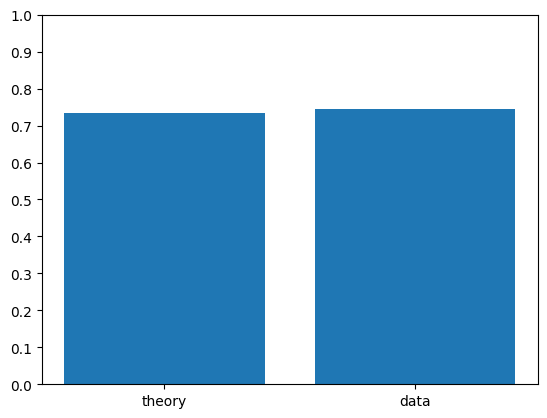

In [91]:
theory_acc = trapz(up_all_t_vec, t_pts)
data_acc = len(data_df_led_off_with_aborts_cond_filtered[data_df_led_off_with_aborts_cond_filtered['correct'] == 1] ) / len(data_df_led_off_with_aborts_cond_filtered)

labels = ['theory', 'data']
plt.bar(labels, [theory_acc, data_acc])
plt.ylim(0,1)
plt.yticks(np.arange(0, 1.1, 0.1));

# tacho

In [93]:
from psiam_tied_dv_map_utils_with_PDFs import rho_A_t_fn, cum_A_t_fn
# prob_EA_hits_either_bound = CDF_E_minus_small_t_NORM_omega_gamma_fn(t - t_stim - t_E_aff + del_go,\
#                                                                          gamma, omega, 1, K_max) \
#                              + CDF_E_minus_small_t_NORM_omega_gamma_fn(t - t_stim - t_E_aff + del_go,\
#                                                                          gamma, omega, -1, K_max)
                                                                      #    gamma, omega, 1, K_max)

# P_E_plus = rho_E_minus_small_t_NORM_omega_gamma_fn(t-t_E_aff-t_stim, gamma, omega, bound, K_max)

def all_RTs_fit_OPTIM_omega_gamma_fn(t, V_A, theta_A, gamma, omega, t_stim, t_A_aff, t_E_aff, t_motor, K_max):
    """
    PDF of all RTs array irrespective of choice
    """

    P_A = rho_A_t_fn(t-t_A_aff-t_motor, V_A, theta_A) 
    C_E = CDF_E_minus_small_t_NORM_omega_gamma_fn(t - t_motor - t_stim - t_E_aff, gamma, omega, 1, K_max) \
           + CDF_E_minus_small_t_NORM_omega_gamma_fn(t - t_motor - t_stim - t_E_aff, gamma, omega, -1, K_max)
    

    P_E = rho_E_minus_small_t_NORM_omega_gamma_fn(t-t_E_aff-t_stim-t_motor, gamma, omega, 1, K_max) \
           + rho_E_minus_small_t_NORM_omega_gamma_fn(t-t_E_aff-t_stim-t_motor, gamma, omega, -1, K_max)
          
    C_A = cum_A_t_fn(t-t_A_aff-t_motor, V_A, theta_A) 

    P_A = np.array(P_A); C_E = np.array(C_E); P_E = np.array(P_E); C_A = np.array(C_A)
    P_all = P_A*(1-C_E) + P_E*(1-C_A)

    return P_all


In [96]:
# up theory
N_theory = int(1e3)
rand_indices = np.random.randint(0, len(t_stim_and_led_tuple), size=N_theory)
t_pts = np.arange(0, 1, 0.02)

# Compute mean values for gamma, omega, and t_E_aff
gamma = gamma_samples.mean()
omega = omega_samples.mean()
t_E_aff = t_E_aff_samples.mean()

print(f'gamma = {gamma}, omega = {omega}, t_E_Afff = { t_E_aff}')

tacho_samples = np.zeros((N_theory, len(t_pts)))

# Function to compute one sample
def compute_tacho_theory_sample(idx):
   
    t_stim, t_LED = t_stim_and_led_tuple[rand_indices[idx]]

    # Compute truncation factor
    # t_pts_trunc = np.arange(t_stim, t_stim + 1, 0.001)
    # P_A_LED_change = np.array([PA_with_LEDON_2(i, V_A, V_A_post_LED, theta_A, 0, t_LED, t_A_aff) for i in t_pts_trunc])
    # area_btn_stim_and_1s = trapz(P_A_LED_change, t_pts_trunc)

    # Compute and return the truncated values
    return np.array([
        max(
            up_RTs_fit_OPTIM_V_A_change_gamma_omega_fn(rt + t_stim, t_LED, V_A, V_A_post_LED, theta_A,
                                                        gamma, omega, t_stim, t_A_aff, t_E_aff, del_go, K_max) 
            / (all_RTs_fit_OPTIM_omega_gamma_fn(rt + t_stim, V_A, theta_A, gamma, omega, t_stim, t_A_aff, t_E_aff, 0, K_max) + 1e-50), 1e-50
        ) for rt in t_pts
    ])

# Parallel computation
results = Parallel(n_jobs=30)(delayed(compute_tacho_theory_sample)(idx) for idx in tqdm(range(N_theory)))

# Convert results to numpy array
tacho_samples = np.array(results)


Text(0, 0.5, 'accuracy')

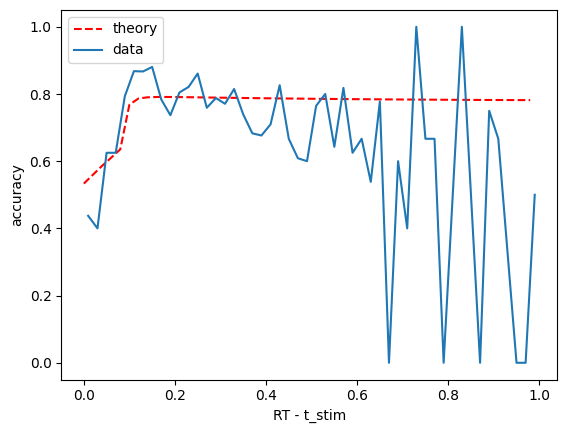

In [ ]:
tacho_mean = np.mean(tacho_samples, axis=0)
plt.plot(t_pts, tacho_mean, color='r', ls='--', label='theory')

bins = np.arange(0, 2, 0.02)

data_df_led_off_with_aborts_cond_filtered = data_df_led_off_with_aborts_cond_filtered.copy()
data_df_led_off_with_aborts_cond_filtered['RT_bin'] = pd.cut(data_df_led_off_with_aborts_cond_filtered['rt'] - data_df_led_off_with_aborts_cond_filtered['t_stim'],\
                                                              bins = bins, include_lowest=True)
grouped_by_rt_bin = data_df_led_off_with_aborts_cond_filtered.groupby('RT_bin', observed=False)['correct'].agg(['mean', 'count'])
grouped_by_rt_bin['bin_mid'] = grouped_by_rt_bin.index.map(lambda x: x.mid)
plt.plot(grouped_by_rt_bin['bin_mid'], grouped_by_rt_bin['mean'], label='data')

plt.legend()
plt.xlabel('RT - t_stim')
plt.ylabel('accuracy')

# All 4 plots in one!

<Figure size 600x600 with 0 Axes>

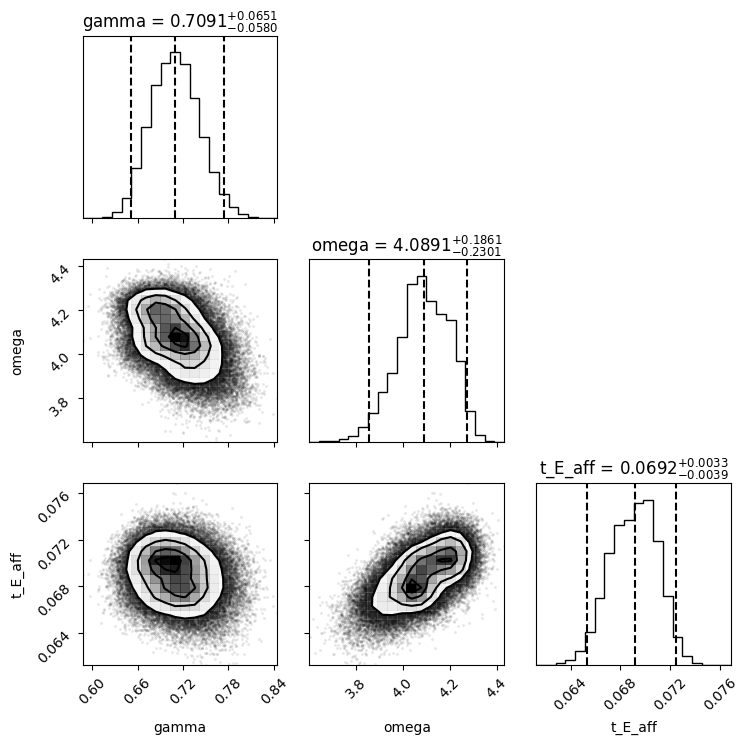

Up areas: data = 0.673, theory = 0.668
Down areas: data = 0.184, theory  = 0.188


/tmp/ipykernel_3690438/1309543701.py:43: DeprecationWarning: 'scipy.integrate.trapz' is deprecated in favour of 'scipy.integrate.trapezoid' and will be removed in SciPy 1.14.0
  print(f'Up areas: data = {frac_up_data:.3f}, theory = {trapz(up_theory_mean, t_pts):.3f}')
/tmp/ipykernel_3690438/1309543701.py:44: DeprecationWarning: 'scipy.integrate.trapz' is deprecated in favour of 'scipy.integrate.trapezoid' and will be removed in SciPy 1.14.0
  print(f'Down areas: data = {frac_down_data:.3f}, theory  = {trapz(down_theory_mean, t_pts):.3f}')


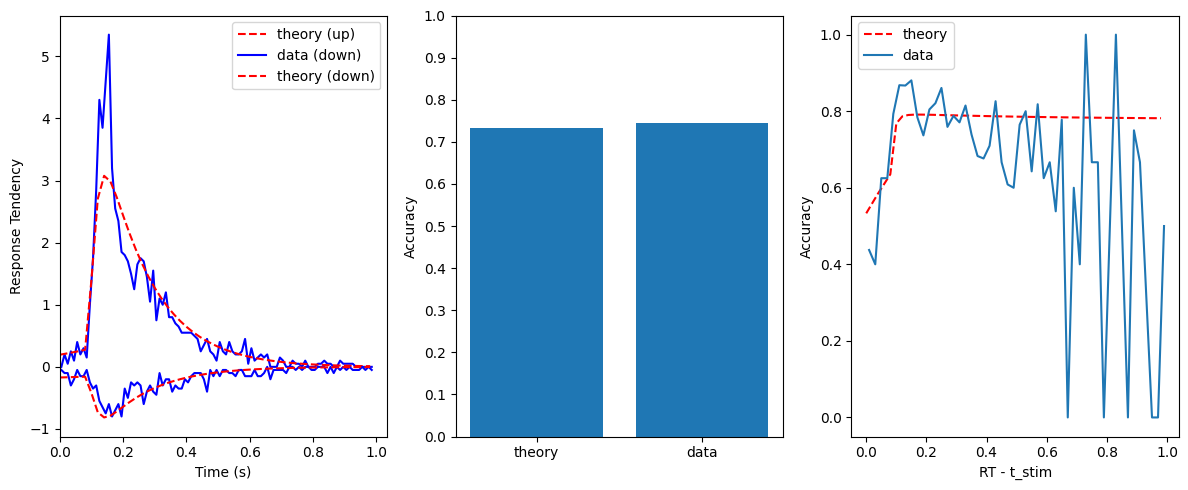

In [105]:
import matplotlib.pyplot as plt
import corner
import numpy as np
import pandas as pd
from scipy.integrate import trapz

# -------------------------------
# 1. Corner Plot (Separate Figure)
# -------------------------------
fig_corner = plt.figure(figsize=(6, 6))
corner.corner(
    corner_samples,
    labels=param_labels,
    show_titles=True,
    quantiles=[0.025, 0.5, 0.975],
    range=_ranges,
    title_fmt=".4f"
)
plt.tight_layout()
plt.show()

# -------------------------------
# 2. Create 3×1 Figure for Other Plots
# -------------------------------
fig, axes = plt.subplots(1, 3, figsize=(12, 5))

# Subplot 1: RTDs
ax1 = axes[0]
ax1.plot(bin_centers, data_up_rt_hist * frac_up_data, color='b')
up_theory_mean = np.mean(up_rt_theory_samples, axis=0)
ax1.plot(t_pts, up_theory_mean, label='theory (up)', color='r', ls='--')

ax1.plot(bin_centers, -data_down_rt_hist * frac_down_data, color='b', label='data (down)')
down_theory_mean = np.mean(down_rt_theory_samples, axis=0)
ax1.plot(t_pts, -down_theory_mean, color='r', ls='--', label='theory (down)')

ax1.set_xlim(left=0)
ax1.legend()
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Response Tendency')

# (Optional) Print area comparisons
print(f'Up areas: data = {frac_up_data:.3f}, theory = {trapz(up_theory_mean, t_pts):.3f}')
print(f'Down areas: data = {frac_down_data:.3f}, theory  = {trapz(down_theory_mean, t_pts):.3f}')

# Subplot 2: Accuracy Bar Plot
ax2 = axes[1]
labels_bar = ['theory', 'data']
ax2.bar(labels_bar, [theory_acc, data_acc])
ax2.set_ylim(0, 1)
ax2.set_yticks(np.arange(0, 1.1, 0.1))
ax2.set_ylabel('Accuracy')

# Subplot 3: Tacho Plot
ax3 = axes[2]
tacho_mean = np.mean(tacho_samples, axis=0)
ax3.plot(t_pts, tacho_mean, color='r', ls='--', label='theory')

bins = np.arange(0, 2, 0.02)
data_df = data_df_led_off_with_aborts_cond_filtered.copy()
data_df['RT_bin'] = pd.cut(
    data_df['rt'] - data_df['t_stim'],
    bins=bins,
    include_lowest=True
)
grouped_by_rt_bin = data_df.groupby('RT_bin', observed=False)['correct'].agg(['mean', 'count'])
grouped_by_rt_bin['bin_mid'] = grouped_by_rt_bin.index.map(lambda x: x.mid)

ax3.plot(grouped_by_rt_bin['bin_mid'], grouped_by_rt_bin['mean'], label='data')
ax3.legend()
ax3.set_xlabel('RT - t_stim')
ax3.set_ylabel('Accuracy')

# Final layout
plt.tight_layout()
plt.show()


# check if theory is correct

In [ ]:
# theory to match it
# t_stim_and_led_tuple
N_theory = int(1e3)
rand_indices = np.random.randint(0, len(t_stim_and_led_tuple), size=N_theory)
t_pts = np.arange(-1, 1, 0.02)
up_rt_theory_samples = np.zeros((N_theory, len(t_pts)))
for idx in tqdm(range(N_theory)):
    ABL = np.random.choice(conditions['ABL'])
    ILD = np.random.choice(conditions['ILD'])
    t_stim, t_LED = t_stim_and_led_tuple[rand_indices[idx]]
    up_rt_theory_samples[idx, :] = np.array([up_RTs_fit_OPTIM_V_A_change_added_noise_M3_delGO_fn(rt + t_stim, t_LED, V_A, V_A_post_LED, theta_A, \
                                                        ABL, ILD, rate_lambda, T_0, noise,\
                                                            theta_E, Z_E, t_stim, t_A_aff, t_E_aff, del_go, K_max) \
                                                            for rt in t_pts])

In [ ]:
sim_results_df_up = sim_results_df[sim_results_df['choice'] == 1]
sim_rt_up = sim_results_df_up['rt']  - sim_results_df_up['t_stim']
bins = np.arange(-1, 1, 0.02)
sim_up_hist, _ = np.histogram(sim_rt_up, bins=bins, density=True)
sim_up_frac = len(sim_rt_up) / len(sim_results_df)
bin_centers = (bins[:-1] + bins[1:]) / 2

In [ ]:
up_rt_theory_mean = np.mean(up_rt_theory_samples, axis=0)
plt.plot(t_pts, up_rt_theory_mean)
plt.plot(bin_centers, sim_up_hist*sim_up_frac, color='r', ls='--')

print(f'sim up frac = {frac_up_sim}, area under theory = {trapz(up_rt_theory_mean, t_pts)}')

## diag vars

In [ ]:
sim_diag_with_aborts = Diagnostics(sim_results_df_with_aborts)
sim_diag_valid = Diagnostics(sim_results_df_valid)

data_diag_with_aborts = Diagnostics(data_df_led_off_with_aborts)
data_diag_valid = Diagnostics(data_df_led_off_valid)

## plot design diag

In [ ]:
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec

fig = plt.figure(figsize=(12*3, 18*3))
gs = GridSpec(nrows=5, ncols=5, figure=fig, hspace=0.1, wspace=0.05, height_ratios=[1, 0.5, 0.5, 0.5, 1])


# Create a sub‐GridSpec for row=0, spanning all columns
top_gs = gs[0, :]  # entire top row
top_subgs = GridSpecFromSubplotSpec(
    1, 3,                      # 1 row × 3 columns
    subplot_spec=top_gs,       # link to the main row=0
    width_ratios=[1.2, 1, 1.6],
    wspace=0.3              # horizontal spacing
)

# Make three subplots from top_subgs
ax_rtd     = fig.add_subplot(top_subgs[0, 0])
ax_psy     = fig.add_subplot(top_subgs[0, 1])
ax_chrono  = fig.add_subplot(top_subgs[0, 2])



ABL_colors = {20: 'r', 40: 'b', 60: 'g'}
ILD_colors = {1: 'r', 2: 'b', 4: 'g', 8: 'm', 16: 'k'}

### Grand RTD ###
bins = np.arange(-2, 2, 0.005)
x, y = sim_diag_with_aborts.plot_rtd_wrt_stim(bins)
ax_rtd.plot(x, y, label='sim', ls='--', color='r')

x, y = data_diag_with_aborts.plot_rtd_wrt_stim(bins)
ax_rtd.plot(x, y, label='data', color='b')

ax_rtd.set_title('right trunc, trunc aborts removed RTD', fontsize=18)
ax_rtd.set_xlabel('RT(s)', fontsize=25)
ax_rtd.tick_params(axis='both', which='major', labelsize=20)
ax_rtd.legend(fontsize=12)
ax_rtd.spines['top'].set_visible(False)
ax_rtd.spines['right'].set_visible(False)
ax_rtd.spines['left'].set_visible(False)
ax_rtd.set_yticks([])
ax_rtd.spines['bottom'].set_visible(True)
ax_rtd.set_xlim(-1,1)
ax_rtd.set_ylim(bottom=0)

### END of Grand RTD ###

### Accuracy vs abs ILD ###
data_psycho = data_diag_valid.plot_psycho()
all_ABL = data_psycho.keys()
all_ILD = np.sort(df['ILD'].unique())
all_pos_ILD = list(set(np.abs(df['ILD'].unique())))

sim_psycho = sim_diag_valid.plot_psycho()
for ABL in all_ABL:
    ax_psy.scatter(all_ILD, data_psycho[ABL], label=f'ABL={ABL}', color=ABL_colors[ABL], s=150)
    ax_psy.plot(all_ILD, sim_psycho[ABL], alpha=0.9, color=ABL_colors[ABL])

ax_psy.set_xlabel('ILD', fontsize=25)
ax_psy.set_ylabel('Prob Correct', fontsize=25)
ax_psy.set_title('rt btn t_stim and t_stim + 1s', fontsize=18)
ax_psy.legend(fontsize=18)
ax_psy.spines['top'].set_visible(False)
ax_psy.spines['right'].set_visible(False)
ax_psy.spines['left'].set_visible(True)
ax_psy.spines['bottom'].set_visible(True)
ax_psy.tick_params(axis='x', which='major', labelsize=25)
ax_psy.tick_params(axis='y', which='major', labelsize=25)
ax_psy.set_yticks([0.5,0.75, 1.0])
ax_psy.axvline(0, color='k', ls='--', alpha=0.3)
ax_psy.axhline(0.5, color='k', ls='--', alpha=0.3)

### END of Accuracy vs abs ILD ###



### Chrono ###
x, sim_chrono = sim_diag_valid.plot_chrono_median()
for ABL in sim_chrono.keys():
    ax_chrono.plot(x, sim_chrono[ABL], color='r')

x, data_chrono = data_diag_valid.plot_chrono_median()
for ABL in data_chrono.keys():
    ax_chrono.scatter(x, data_chrono[ABL], label=f'data ABL={ABL}', color='b', marker='.', s=500)
# ax_chrono.legend(fontsize=18) # psycho covers it
ax_chrono.set_xlabel(' abs ILD', fontsize=25)
ax_chrono.set_ylabel('MEDIAN RT(s)', fontsize=25)
ax_chrono.set_title('chrono', fontsize=25)
ax_chrono.spines['top'].set_visible(False)
ax_chrono.spines['right'].set_visible(False)
ax_chrono.spines['left'].set_visible(True)
ax_chrono.spines['bottom'].set_visible(True)
ax_chrono.tick_params(axis='both', which='both', labelsize=25)
ax_chrono.set_xlim(0.9, 8.1)
ax_chrono.set_yticks(np.arange(0.1, 0.4, 0.1))
ax_chrono.set_ylim(0.1, 0.3)

### END of Chrono ###

### RTDs per ABL ###
# Get all positive ILDs (do not exclude the last one)
# Precompute quantile dictionaries using the provided function
sim_quantiles = sim_diag_valid.plot_quantile()  # {ABL: {ILD: [q10, q30, q50, q70, q90]}}
data_quantiles = data_diag_valid.plot_quantile()

# Get all positive ILDs (do not drop the last one)
bins = np.arange(-2, 2, 0.02)

for a, ABL in enumerate(ABL_arr):
    row = a + 1
    for j, ILD in enumerate(all_pos_ILD):
        ax = fig.add_subplot(gs[row, j])
        
        # For all but the last column, plot the histograms for that abs ILD
        if j < len(all_pos_ILD) - 1:
            # Filter for current ABL and ILD (both signs)
            sim_pd = sim_results_df_with_aborts[(sim_results_df_with_aborts['ABL'] == ABL) & (sim_results_df_with_aborts['ILD'].isin([ILD, -ILD]))]
            sim_rt = sim_pd['rt'] - sim_pd['t_stim']
            
            data_pd = data_df_led_off_with_aborts[(data_df_led_off_with_aborts['ABL'] == ABL) & (data_df_led_off_with_aborts['ILD'].isin([ILD, -ILD]))]
            data_rt = data_pd['rt'] - data_pd['t_stim']
            
            sim_rt_hist, _ = np.histogram(sim_rt, density=True, bins=bins)
            data_rt_hist, _ = np.histogram(data_rt, density=True, bins=bins)
            t_pts = bins[:-1] + 0.5*(bins[1] - bins[0])
            
            ax.step(t_pts, data_rt_hist, label=f'data ILD={ILD}', color='b')
            ax.step(t_pts, sim_rt_hist, linestyle='dashed', color='r', label='sim', linewidth=3)
        
            if a == len(ABL_arr) - 1:
                ax.set_xlabel('RT(s) / ILD', fontsize=25)
            if j == 0:
                ax.set_ylabel(f'ABL={ABL}', fontsize=25)
                ax.tick_params(axis='y', which='major', labelsize=20)

            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.spines['bottom'].set_visible(True)
            if j != 0:
                ax.spines['left'].set_visible(False)

            ax.set_yticks([])
            ax.set_xlim(-0.3,0.7)
            ax.set_ylim(bottom=0)



        else:
            sim_qs = [sim_quantiles[ABL][ild] for ild in all_pos_ILD]
            data_qs = [data_quantiles[ABL][ild] for ild in all_pos_ILD]

            sim_qs = np.array(sim_qs)
            data_qs = np.array(data_qs)

            ax.plot(all_pos_ILD[:-1], sim_qs[:-1,:], lw=3,color='r')
            ax.plot(all_pos_ILD[:-1], data_qs[:-1,:], linestyle='', marker='.', markersize=25, color='b')
            ax.set_title('Quantiles', fontsize=16)

            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.spines['bottom'].set_visible(True)
        
            # increase font size of x-axis labels
            ax.tick_params(axis='x', which='major', labelsize=25)
            ax.tick_params(axis='y', which='major', labelsize=25)
            ax.set_ylim(0.1, 0.5)
            ax.set_yticks(np.arange(0.1, 0.6, 0.1))
            ax.set_xticks(all_pos_ILD[:-1])
        # Format spines
        
        
        # Hide x-ticks for non-bottom rows
        if a < len(ABL_arr) - 1:
            ax.set_xticks([])


## END OF RTDs per ABL ### 

### Tachos per ABL ###
# --- Bottom row (row=4) => sub‐GridSpec 1×3 ---
bottom_gs = GridSpecFromSubplotSpec(
    1, 3, 
    subplot_spec=gs[4, 0:5],  # entire last row, columns 0..4
    wspace=0.2,
)

# “Blank” top sub‐row
ax_spacer = fig.add_subplot(bottom_gs[0, :])
ax_spacer.axis("off") 

ax_tacho_20 = fig.add_subplot(bottom_gs[0, 0])
ax_tacho_40 = fig.add_subplot(bottom_gs[0, 1])
ax_tacho_60 = fig.add_subplot(bottom_gs[0, 2])

ax_list  = [ax_tacho_20, ax_tacho_40, ax_tacho_60]

# hard_ILD = np.array([1, 2, 4, -1, -2, -4]); easy_ILD = np.array([8, 16, -8, -16])
hard_ILD = np.array([1, -1, 2, -2]); easy_ILD = np.array([4, -4, 8, -8])

bins = np.arange(0, 1, 0.02)
for a, ABL in enumerate(ABL_arr):
    ax_r = ax_list[a]

    # sim - easy
    sim_pd_easy = sim_results_df_valid[(sim_results_df_valid['ABL'] == ABL) & (sim_results_df_valid['ILD'].isin(easy_ILD))]
    sim_pd_easy_diag = Diagnostics(sim_pd_easy)
    x, sim_easy_tacho = sim_pd_easy_diag.plot_tacho(bins)
    ax_r.plot(x, sim_easy_tacho, linestyle='dashed', label='sim easy', color='g')
    
    # sim - hard
    sim_pd_hard = sim_results_df_valid[(sim_results_df_valid['ABL'] == ABL) & (sim_results_df_valid['ILD'].isin(hard_ILD))]
    sim_pd_hard_diag = Diagnostics(sim_pd_hard)
    x, sim_hard_tacho = sim_pd_hard_diag.plot_tacho(bins)
    ax_r.plot(x, sim_hard_tacho, label='sim hard', color='r', linestyle='dashed')

    # data - easy
    data_pd_easy = data_df_led_off_valid[ (data_df_led_off_valid['ABL'] == ABL) & (data_df_led_off_valid['ILD'].isin(easy_ILD))]
    data_pd_easy_diag = Diagnostics(data_pd_easy)
    x, data_easy_tacho = data_pd_easy_diag.plot_tacho(bins)
    ax_r.plot(x, data_easy_tacho, label='data easy', color='g')

    # data - hard
    data_pd_hard = data_df_led_off_valid[ (data_df_led_off_valid['ABL'] == ABL) & (data_df_led_off_valid['ILD'].isin(hard_ILD))]
    data_pd_hard_diag = Diagnostics(data_pd_hard)
    x, data_hard_tacho = data_pd_hard_diag.plot_tacho(bins)
    ax_r.plot(x, data_hard_tacho, label='data hard', color='r')

    ax_r.set_title(f'ABL = {ABL}', fontsize=25)
    ax_r.set_xlabel('RT(s)', fontsize=25)
    if a == 0:
        ax_r.legend(fontsize=18)
        ax_r.set_ylabel('accuracy', fontsize=25)

    ax_r.set_xlim(0, 0.6)
    ax_r.set_ylim(0.3, 1.1)
    ax_r.spines['top'].set_visible(False)
    ax_r.spines['right'].set_visible(False)
    ax_r.spines['left'].set_visible(True)
    ax_r.spines['bottom'].set_visible(True)
    if a == 0:
        ax_r.set_yticks(np.arange(0.2, 1.2, 0.2))

    if a != 0:
        ax_r.spines['left'].set_visible(False)
        ax_r.set_yticks([])
    
    ax_r.tick_params(axis='both', which='major', labelsize=20)
    ax_r.tick_params(axis='x', which='major', labelsize=25)




# calc likelihoods on data

In [ ]:
# print params
print(f'V_A = {V_A}, theta_A = {theta_A}, V_A_post_LED = {V_A_post_LED}, t_A_aff = {t_A_aff}, t_E_aff = {t_E_aff}, del_go = {del_go},\
       Z_E = {Z_E}, K_max = {K_max}')
print(f'rate_lambda = {rate_lambda}, noise = {noise}')
print(f'T_0 = {T_0*1000 : .2f} ms, theta_E = {theta_E}')

In [ ]:
# total likelihood
print(f'T_0: {T_0*1000 :.2f} ms, theta_E: {theta_E: .2f}')
# loglike_rt_choice = vbmc_loglike_fn([T_0, theta_E])
loglike_rt_choice = 0
for _, row in df_led_off_valid_trials.iterrows():
        response_poke = row['response_poke']
        rt = row['timed_fix']
        t_stim = row['intended_fix']
        t_LED = row['intended_fix'] - row['LED_onset_time']
        ABL = row['ABL']
        ILD = row['ILD']
        
        if response_poke == 3:
            # up
            likelihood = up_RTs_fit_OPTIM_V_A_change_added_noise_M3_delGO_fn(rt, t_LED, V_A, V_A_post_LED, theta_A, \
                                                            ABL, ILD, rate_lambda, T_0, noise,\
                                                                theta_E, Z_E, t_stim, t_A_aff, t_E_aff, del_go, K_max)
        elif response_poke == 2:
            # down
            likelihood = down_RTs_fit_OPTIM_V_A_change_added_noise_M3_delGO_fn(rt, t_LED, V_A, V_A_post_LED, theta_A, \
                                                            ABL, ILD, rate_lambda, T_0, noise,\
                                                                theta_E, Z_E, t_stim, t_A_aff, t_E_aff, del_go, K_max)
    
        loglike_rt_choice += np.log(likelihood)

In [ ]:
# loglike
loglike_rt = 0
loglike_rt_2 = 0
for _, row in tqdm(df_led_off_valid_trials.iterrows()):
    rt = row['timed_fix']
    t_stim = row['intended_fix']
    t_LED = row['intended_fix'] - row['LED_onset_time']
    ABL = row['ABL']
    # ILD = row['ILD']
    # TEMP: TRYING WITH ABS ILD
    ILD = np.abs(row['ILD'])
    
    like_rt = all_RTs_fit_OPTIM_V_A_change_added_noise_fn(rt, t_LED, V_A, V_A_post_LED, theta_A, ABL, ILD, \
                                            rate_lambda, T_0, noise, theta_E, Z_E, t_stim, t_A_aff, t_E_aff, K_max)
    
    # all_RTs_fit_OPTIM_fn(t, V_A, theta_A, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, t_stim, t_A_aff, t_E_aff, t_motor, K_max)
    like_rt_2 = all_RTs_fit_OPTIM_fn(rt, V_A, theta_A, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, t_stim, t_A_aff, t_E_aff, 0, K_max)
    
    loglike_rt += np.log(like_rt)
    loglike_rt_2 += np.log(like_rt_2)
                        

In [ ]:
print(f'loglike RT new func : {loglike_rt :.2f}, loglike RT old func : {loglike_rt_2 :.2f}')

In [ ]:
##### check that likelihood is correct
# theory
N_theory = int(10e3)
sample_indices = np.random.choice(len(t_stim_and_led_tuple), N_theory)
t_pts = np.arange(0, 1, 0.02)
rt_like_samples = np.zeros((N_theory, len(t_pts)))
for idx in tqdm(range(N_theory)):
    t_stim, t_LED = t_stim_and_led_tuple[sample_indices[idx]]
    ABL = np.random.choice(ABL_arr)
    ILD = np.random.choice(ILD_arr)

    rt_like_samples[idx, :] = np.array([all_RTs_fit_OPTIM_fn(rt + t_stim, V_A, theta_A, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, t_stim, t_A_aff, t_E_aff, 0, K_max) \
                                         for rt in t_pts])



In [ ]:
# theory
rt_like_samples_mean = np.mean(rt_like_samples, axis=0)
plt.plot(t_pts, rt_like_samples_mean, label='theory', lw=2)

# data
num_df_led_off = len(df[df['LED_trial'] == 0])
num_df_led_off_valid_less_than_1s = len(df[ (df['LED_trial'] == 0) & \
                                        (df['timed_fix'] - df['intended_fix'] < 1) & \
                                        (df['timed_fix'] - df['intended_fix'] > 0) ])

frac_led_off = num_df_led_off_valid_less_than_1s / num_df_led_off

bins = np.arange(0, 1, 0.02)
test_led_off_valid_rt = df_led_off_valid_trials['timed_fix'] - df_led_off_valid_trials['intended_fix']
data_hist, _ = np.histogram(test_led_off_valid_rt, bins=bins, density=True)
bin_centers = bins[:-1] + 0.5*(bins[1] - bins[0])
data_hist *= frac_led_off
plt.plot(bin_centers, data_hist, label='data')

# sim
test_sim_rt_df = sim_results_df[(sim_results_df['rt'] - sim_results_df['t_stim'] < 1) * \
                             (sim_results_df['rt'] - sim_results_df['t_stim'] > 0)]

test_sim_rt_wrt_stim = test_sim_rt_df['rt'] - test_sim_rt_df['t_stim']
sim_hist, _ = np.histogram(test_sim_rt_wrt_stim, bins=bins, density=True)
sim_hist *= len(test_sim_rt_wrt_stim) / len(sim_results_df)
plt.plot(bin_centers, sim_hist, label='sim', ls='--', color='r')


# area under thheory and data
print(f'area under theory: {trapz(rt_like_samples_mean, t_pts)}')
print(f'area under data: {trapz(data_hist, bin_centers)}')
plt.legend()

In [ ]:
print(f'loglike(rt, choice) = {loglike_rt_choice:.3f}')
print(f'loglike(rt) = {loglike_rt:.3f}')
print(f'loglike(choice | RT) = {loglike_rt_choice - loglike_rt:.3f}')

In [ ]:
loglike_choice_given_rt = 0

for _, row in tqdm(df_led_off_valid_trials.iterrows()):
    rt = row['timed_fix']
    t_stim = row['intended_fix']
    t_LED = row['intended_fix'] - row['LED_onset_time']
    ABL = row['ABL']
    ILD = row['ILD']
    response_poke = row['response_poke']

    if response_poke == 3:
            # up
        likelihood_num = up_RTs_fit_OPTIM_V_A_change_added_noise_M3_delGO_fn(rt, t_LED, V_A, V_A_post_LED, theta_A, \
                                                        ABL, ILD, rate_lambda, T_0, noise,\
                                                            theta_E, Z_E, t_stim, t_A_aff, t_E_aff, del_go, K_max)
    elif response_poke == 2:
        # down
        likelihood_num = down_RTs_fit_OPTIM_V_A_change_added_noise_M3_delGO_fn(rt, t_LED, V_A, V_A_post_LED, theta_A, \
                                                        ABL, ILD, rate_lambda, T_0, noise,\
                                                            theta_E, Z_E, t_stim, t_A_aff, t_E_aff, del_go, K_max)
        
    like_den = all_RTs_fit_OPTIM_V_A_change_added_noise_fn(rt, t_LED, V_A, V_A_post_LED, theta_A, ABL, ILD, \
                                            rate_lambda, T_0, noise, theta_E, Z_E, t_stim, t_A_aff, t_E_aff, K_max)
    
    like_choice_given_rt = likelihood_num / like_den
    loglike_choice_given_rt += np.log(like_choice_given_rt)
    


In [ ]:
print(f'loglike(choice | RT) = {loglike_choice_given_rt:.3f}')
print(f'loglike(choice | RT) = {loglike_rt_choice - loglike_rt:.3f}')